### 导入数据

In [27]:
%matplotlib inline
import os
import glob
import xgboost
import operator
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score,LeaveOneOut
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,roc_auc_score,roc_curve,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

#导入数据
df = pd.read_excel(r"E:\Desktop\Desktop\Kidney\51例\ap_test.xlsx")
target=df.iloc[:,1:2]
features=df.iloc[:,2:102]
features_names=list(features.columns)

#不标准化数据
X_data_2 = features
y_data_2 = target

#标准化所有数据
scaler = StandardScaler()#scaler = MinMaxScaler()#scaler = RobustScaler()
X_data_1 = pd.DataFrame(scaler.fit_transform(features),columns=features_names)
y_data_1 = target

### 随机森林+RFECV

In [ ]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=239)
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)

names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_2.loc[:, names]

In [ ]:
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [5,6,7],
          'clf__min_samples_leaf' : [1,2,3],
          'clf__min_samples_split' : [5,6,7],
          'clf__n_estimators': [7,8,9,10]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_) 

In [ ]:
#best_clf=RandomForestClassifier(criterion='gini', max_depth=3, max_features='auto', min_samples_leaf=3,
#                                min_samples_split=5, n_estimators=9, random_state=1,n_jobs=-1,class_weight="balanced")
best_clf=RandomForestClassifier(criterion='gini', max_depth=6, max_features='log2', min_samples_leaf=1,
                                min_samples_split=6, n_estimators=9, random_state=1,n_jobs=-1,class_weight="balanced")
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=239)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                'Precision': [np.mean(pre)],
                'F1-score': [np.mean(f1)]
                }
    
result = pd.DataFrame(result_dict, index=['Random forest'])
result

### SVM+RFECV

In [ ]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

sm = SMOTE(random_state=239)
clf = SVC(kernel = "linear",random_state=1,probability=True)
estimator = ([("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_1, y_data_1)

names = list(X_data_1.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_1.loc[:, names]

In [ ]:
#网格搜索最佳参数
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__kernel' : ['linear'],
          'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,3,4,5,6,7,10]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_1)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

In [ ]:
best_clf=SVC(kernel = "linear",C=5,random_state=1,probability=True)

cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_1): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=239)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
    
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['SVM'])
result

### XGBoost

In [ ]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

scaler = StandardScaler()
sm = SMOTE(random_state=239)
clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
xgboost.set_config(verbosity=0)  
estimator = ([("stand",scaler),("sample", sm),("clf", clf)])
pipeline = Mypipeline(estimator)
    
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
rfecv.fit(X_data_2, y_data_2)
    
names = list(X_data_2.columns[rfecv.support_])
print('选择的特征子集为：', names)
print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
g_scores = rfecv.grid_scores_
indices = np.argsort(g_scores)[::-1]
print("Grid_Score: %f" % (g_scores[indices[0]]))
select_features = X_data_2.loc[:, names]

In [ ]:
model = Pipeline([("stand",scaler),("sample", sm),("clf", clf)])
score={'AUC':'roc_auc', 'RECALL':'recall','PRECISION':'precision','F1':'f1'}
params = {'clf__colsample_bytree' : [0.1,0.2],
          'clf__gamma' : [0.1,0.2],
          'clf__learning_rate' : [0.01,0.02],
          'clf__max_depth' : [1,2],
          'clf__min_child_weight' : [1,2,3],
          'clf__n_estimators' : [1,2,3],          
          'clf__reg_alpha' : [1,2,3],
          'clf__reg_lambda' : [1,2,3],
          'clf__subsample' : [0.1,0.2,0.3]}
grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
grid_search.fit(select_features, y_data_2)
print("模型最佳参数为：",grid_search.best_params_)
print("模型最佳AUC为：", grid_search.best_score_)

In [ ]:
best_clf=xgboost.XGBClassifier(colsample_bytree=0.1, gamma=0.2, learning_rate=0.01, max_depth=1, 
                               min_child_weight=2, n_estimators=2, reg_alpha=2, reg_lambda=2, 
                               subsample=0.3, random_state=1,n_jobs=-1)
cons = 0
acc = []
pre = []
f1 = []
sen = []
spe = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train_index, test_index in cv.split(select_features, y_data_2): 
    X_train = select_features.iloc[train_index] 
    y_train = y_data_2.iloc[train_index] 
    X_test = select_features.iloc[test_index]
    y_test = y_data_2.iloc[test_index]
        
    scaler = StandardScaler().fit(X_train)
    X_train_scaler = pd.DataFrame(scaler.transform(X_train))
    X_test_scaler = pd.DataFrame(scaler.transform(X_test))
    
    sm = SMOTE(random_state=239)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaler, y_train)
    
    best_clf.fit(X_resampled, y_resampled)
    y_pred = best_clf.predict(X_test_scaler)
    proba = best_clf.predict_proba(X_test_scaler)[:,1]
        
    fpr,tpr,threshold = roc_curve(y_test, proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(roc_auc_score(y_test,proba))
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sen.append(tp/(tp+fn))
    spe.append(tn/(fp+tn))
        
    class_names=['0','1']
    a=confusion_matrix(y_test,y_pred)
    cons=cons+a
#ROC曲线        
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label=r'AUC = %0.2f'% (mean_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()
#混淆矩阵        
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 
std_acc = np.std(acc) 
std_auc = np.std(aucs)   
std_sen = np.std(sen) 
std_spe = np.std(spe) 
result_dict = {'Accuracy': ['±'.join([str(round(np.mean(acc),2)),str(round(np.std(acc),2))])], 
                'Auc': ['±'.join([str(round(np.mean(aucs),2)),str(round(np.std(aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(sen),2)),str(round(np.std(sen),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(spe),2)),str(round(np.std(spe),2))])], 
                }
    
result = pd.DataFrame(result_dict, index=['XGBoost'])
result

### 特征可视化

In [ ]:
import matplotlib.pyplot as plt
clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced") 
clf.fit(select_features,y_data_2)
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
features_names = list(X_data_2.columns[rfecv.support_])
names=[features_names[i] for i in indices]
matplotlib.rcParams.update({'font.size': 15})
#特征重要性排序图
plt.figure(figsize=(5,5))
plt.title=("Feature Importance")
plt.bar(range(select_features.shape[1]),importances[indices])
plt.xticks(range(select_features.shape[1]),names,rotation=90)
plt.show

In [ ]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(select_features)
shap.summary_plot(shap_values, select_features)

### 不同分类器设置不同随机种子并取均值

#### SVM

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 6
选择的特征子集为： ['original_firstorder_Kurtosis', 'original_glcm_ClusterShade', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 'original_shape_Sphericity']
模型最佳参数为： {'clf__C': 2, 'clf__kernel': 'linear'}
模型最佳AUC为： 0.9333333333333333
第 2 次循环
随机种子数为： 30
RFECV 选择出的特征个数 ： 18
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_glcm_ClusterShade', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glszm_GrayLevelNonUniformityNormalized', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy

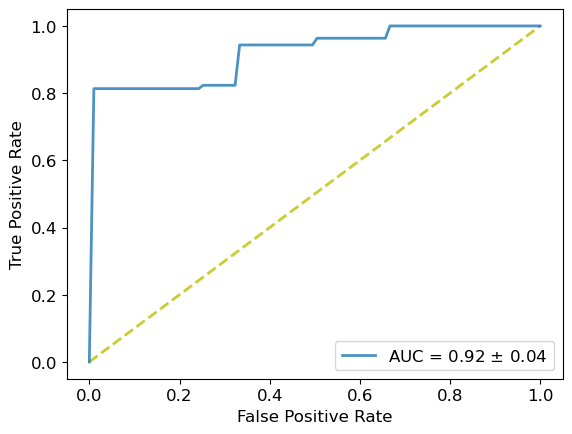

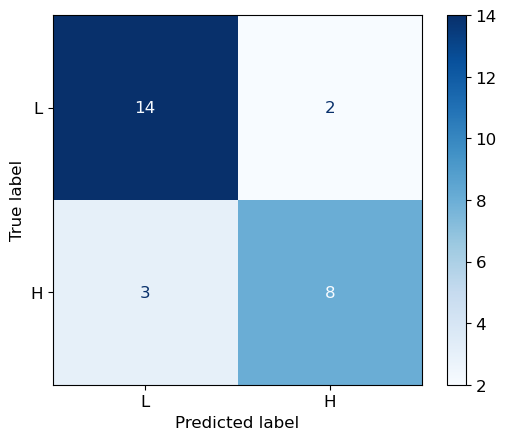

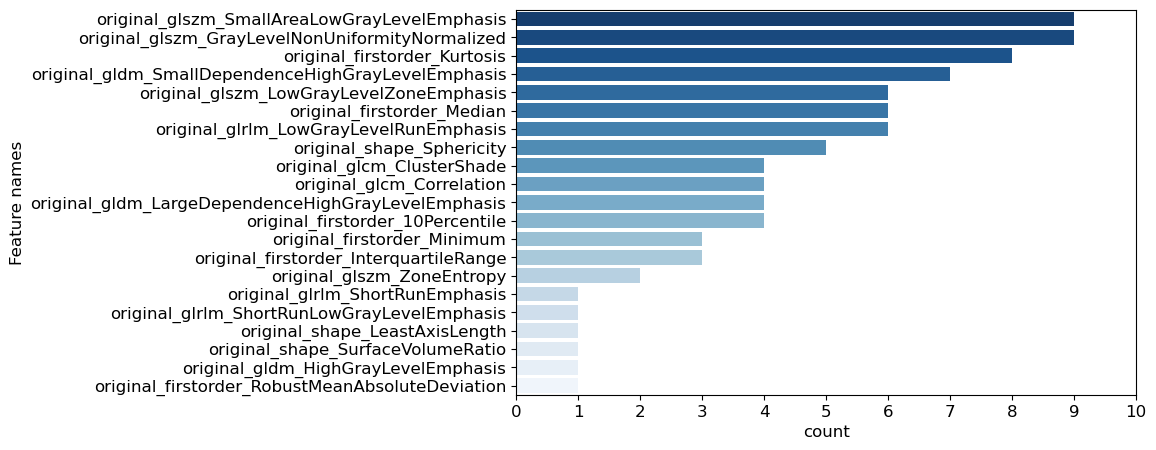

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR),F1 score
SVM,0.82±0.06,0.92±0.04,0.77±0.09,0.86±0.06,0.77±0.07


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

svm_cons = 0
svm_accs = []
svm_aucs = [] 
svm_sens = []
svm_spes = []
svm_f1s = []
svm_tprs = []
n=0
svm_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,30):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = SVC(kernel = "linear",random_state=1,class_weight="balanced",probability=True)
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #svmECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    svm_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    #print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__kernel' : ['linear'],
              'clf__C' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,4,6,8,10,20]}    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score,
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    svm_tprs.append(np.mean(tpr_, axis=0))
    svm_accs.append(np.mean(acc))
    svm_aucs.append(np.mean(auc_))  
    svm_sens.append(np.mean(sen))
    svm_spes.append(np.mean(spe))
    svm_f1s.append(np.mean(f1))
    svm_cons=svm_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
svm_mean_tpr = np.mean(svm_tprs, axis=0)
svm_mean_tpr[-1] = 1.0
svm_mean_auc = auc(mean_fpr, svm_mean_tpr)
svm_std_auc = np.std(svm_aucs)
plt.plot(mean_fpr, svm_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (svm_mean_auc,svm_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(svm_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
svm_select_names = pd.concat([pd.DataFrame(svm_feature_set[i],columns=['Feature names']) for i in range(n)])
svm_result=pd.DataFrame(pd.value_counts(svm_select_names['Feature names']))
plt.figure(figsize=(8, 5))
f = sns.countplot(y='Feature names',data=svm_select_names, order=svm_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
svm_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(svm_accs),2)),str(round(np.std(svm_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(svm_aucs),2)),str(round(np.std(svm_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(svm_sens),2)),str(round(np.std(svm_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(svm_spes),2)),str(round(np.std(svm_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(svm_f1s),2)),str(round(np.std(svm_f1s),2))])] 
                }

result_svm = pd.DataFrame(svm_result_dict, index=['SVM'])
result_svm

In [20]:
svm_mean_auc=0.92

In [21]:
svm_std_auc=0.04

In [3]:
svm_mean_tpr

array([0.        , 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.82333333, 0.82333333, 0.82333333, 0.82333333, 0.82333333,
       0.82333333, 0.82333333, 0.82333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [4]:
svm_mean_auc

0.9197643097643098

In [5]:
svm_std_auc

0.040369627074366886

In [6]:
svm_result

,Feature names
original_glszm_SmallAreaLowGrayLevelEmphasis,9
original_glszm_GrayLevelNonUniformityNormalized,9
original_firstorder_Kurtosis,8
original_gldm_SmallDependenceHighGrayLevelEmphasis,7
original_glszm_LowGrayLevelZoneEmphasis,6
original_firstorder_Median,6
original_glrlm_LowGrayLevelRunEmphasis,6
original_shape_Sphericity,5
original_glcm_ClusterShade,4
original_glcm_Correlation,4


#### 随机森林

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 3
选择的特征子集为： ['original_firstorder_Mean', 'original_firstorder_Median', 'original_glcm_ClusterShade']
模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 9}
模型最佳AUC为： 0.9083333333333334
第 2 次循环
随机种子数为： 30
RFECV 选择出的特征个数 ： 77
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_Uniformity', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_C

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 12}
模型最佳AUC为： 0.7055555555555557
第 5 次循环
随机种子数为： 120
RFECV 选择出的特征个数 ： 97
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency

模型最佳参数为： {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 12}
模型最佳AUC为： 0.7416666666666667
第 8 次循环
随机种子数为： 210
RFECV 选择出的特征个数 ： 42
选择的特征子集为： ['original_firstorder_10Percentile', 'original_firstorder_Kurtosis', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_MaximumProbability', 'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_gldm_LowGrayLevelEmphasis', 'original_gldm_SmallDependenceLowGray

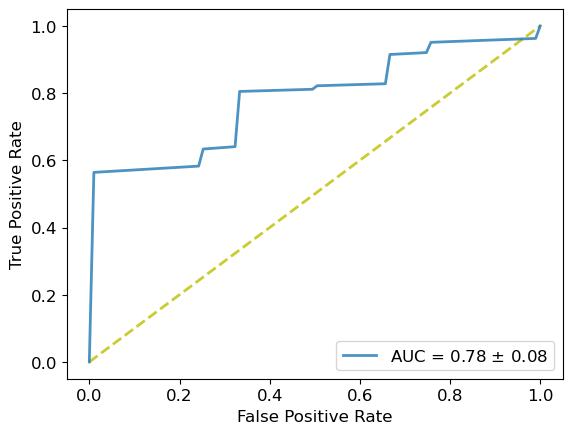

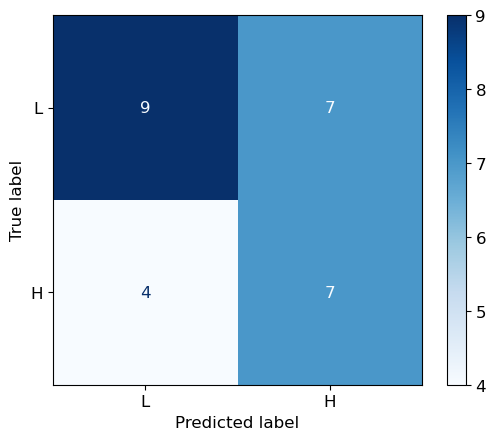

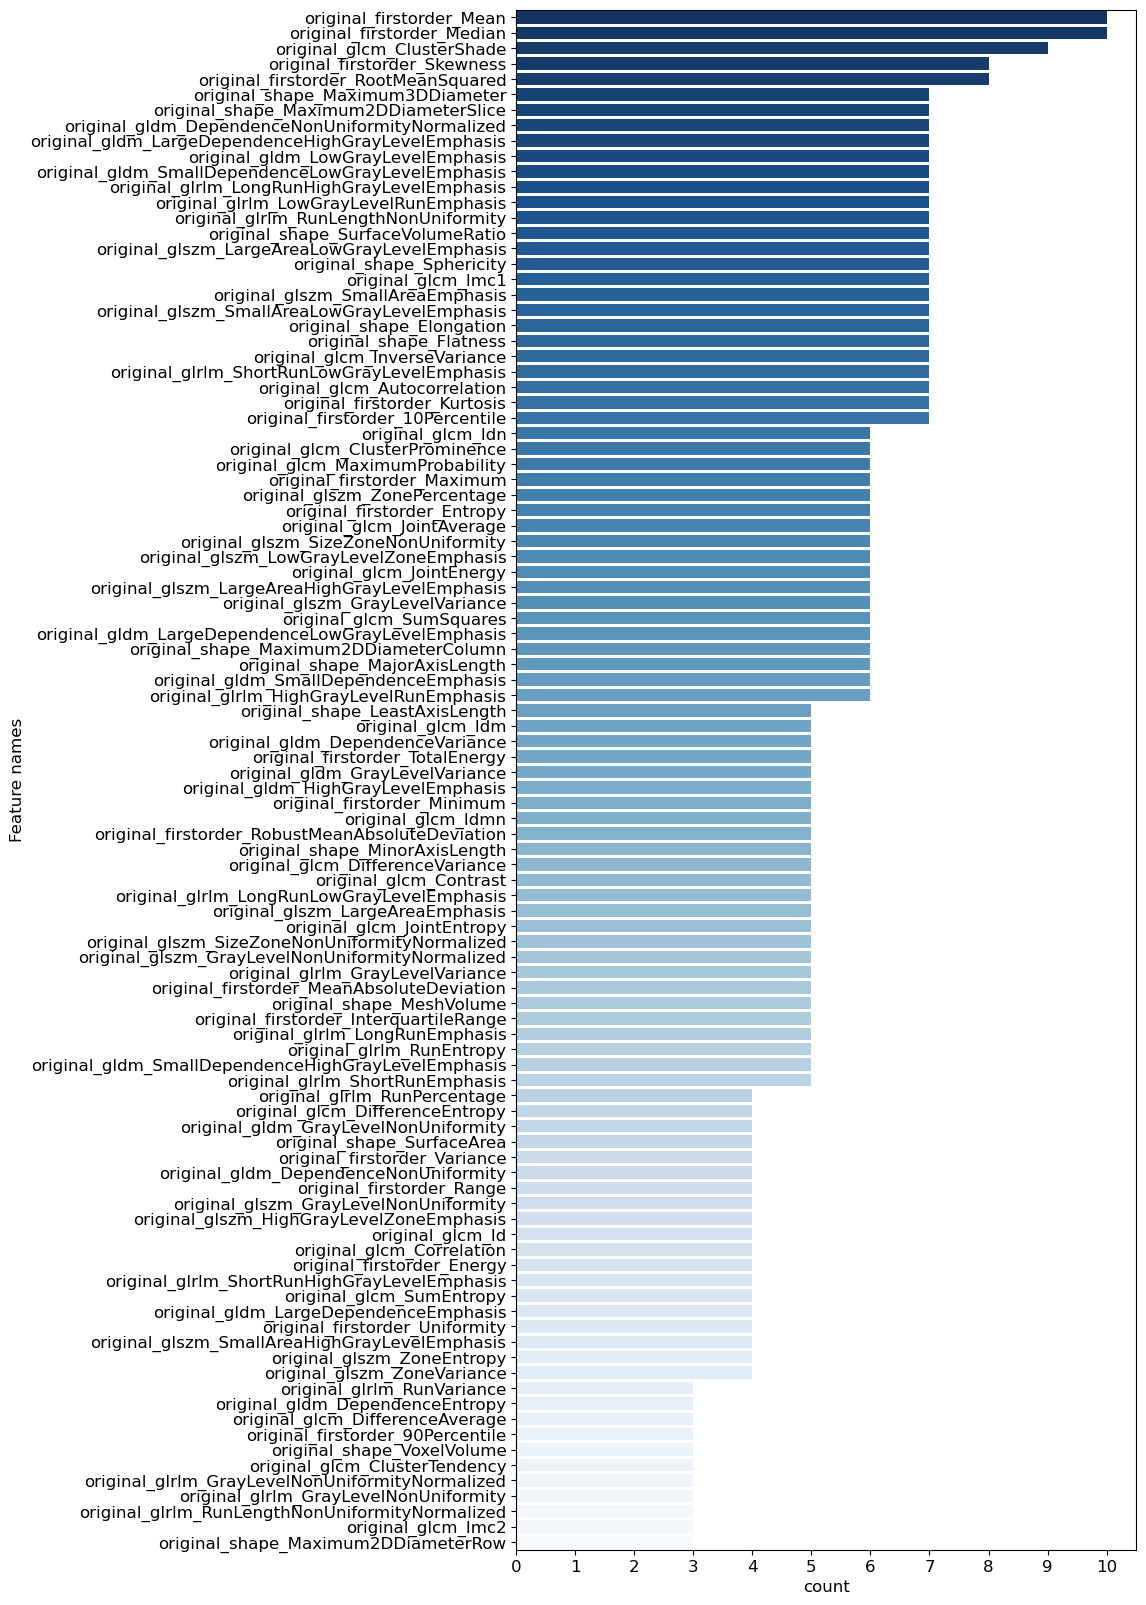

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR),F1 score
RF,0.6±0.08,0.78±0.08,0.69±0.08,0.57±0.1,0.55±0.1


In [2]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

rf_cons = 0
rf_accs = []
rf_aucs = [] 
rf_sens = []
rf_spes = []
rf_f1s = []
rf_tprs = []
n=0
rf_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,30):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = RandomForestClassifier(criterion='gini', random_state=1,n_jobs=-1,class_weight="balanced")
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #RFECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    rf_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
    #print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__criterion' : ['gini'],
          'clf__max_features' : ["auto", "sqrt", "log2"],
          'clf__max_depth': [1,5,9],
          'clf__min_samples_leaf' : [2,6,10],
          'clf__min_samples_split' : [1,5,8],
          'clf__n_estimators': [5,9,12]}   
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score, 
                               n_jobs=-1, 
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    rf_tprs.append(np.mean(tpr_, axis=0))
    rf_accs.append(np.mean(acc))
    rf_aucs.append(np.mean(auc_))  
    rf_sens.append(np.mean(sen))
    rf_spes.append(np.mean(spe))
    rf_f1s.append(np.mean(f1))
    rf_cons=rf_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
rf_mean_tpr = np.mean(rf_tprs, axis=0)
rf_mean_tpr[-1] = 1.0
rf_mean_auc = auc(mean_fpr, rf_mean_tpr)
rf_std_auc = np.std(rf_aucs)
plt.plot(mean_fpr, rf_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (rf_mean_auc,rf_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(rf_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
rf_select_names = pd.concat([pd.DataFrame(rf_feature_set[i],columns=['Feature names']) for i in range(n)])
rf_result=pd.DataFrame(pd.value_counts(rf_select_names['Feature names']))
plt.figure(figsize=(8, 20))
f = sns.countplot(y='Feature names',data=rf_select_names, order=rf_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(n+1))
plt.show()

#模型结果
rf_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(rf_accs),2)),str(round(np.std(rf_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(rf_aucs),2)),str(round(np.std(rf_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(rf_sens),2)),str(round(np.std(rf_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(rf_spes),2)),str(round(np.std(rf_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(rf_f1s),2)),str(round(np.std(rf_f1s),2))])] 
                }

result_rf = pd.DataFrame(rf_result_dict, index=['RF'])
result_rf

In [22]:
rf_mean_auc=0.78

In [23]:
rf_std_auc=0.08

In [3]:
rf_mean_tpr

array([0.        , 0.56414141, 0.56494949, 0.56575758, 0.56656566,
       0.56737374, 0.56818182, 0.5689899 , 0.56979798, 0.57060606,
       0.57141414, 0.57222222, 0.5730303 , 0.57383838, 0.57464646,
       0.57545455, 0.57626263, 0.57707071, 0.57787879, 0.57868687,
       0.57949495, 0.58030303, 0.58111111, 0.58191919, 0.58272727,
       0.63358586, 0.63459596, 0.63560606, 0.63661616, 0.63762626,
       0.63863636, 0.63964646, 0.64065657, 0.805     , 0.80540404,
       0.80580808, 0.80621212, 0.80661616, 0.8070202 , 0.80742424,
       0.80782828, 0.80823232, 0.80863636, 0.8090404 , 0.80944444,
       0.80984848, 0.81025253, 0.81065657, 0.81106061, 0.81146465,
       0.82186869, 0.82227273, 0.82267677, 0.82308081, 0.82348485,
       0.82388889, 0.82429293, 0.82469697, 0.82510101, 0.82550505,
       0.82590909, 0.82631313, 0.82671717, 0.82712121, 0.82752525,
       0.82792929, 0.915     , 0.91570707, 0.91641414, 0.91712121,
       0.91782828, 0.91853535, 0.91924242, 0.91994949, 0.92065

In [4]:
rf_mean_auc

0.783097643097643

In [5]:
rf_std_auc

0.07890258097141452

In [6]:
rf_result

,Feature names
original_firstorder_Mean,10
original_firstorder_Median,10
original_glcm_ClusterShade,9
original_firstorder_Skewness,8
original_firstorder_RootMeanSquared,8
...,...
original_glrlm_GrayLevelNonUniformityNormalized,3
original_glrlm_GrayLevelNonUniformity,3
original_glrlm_RunLengthNonUniformityNormalized,3
original_glcm_Imc2,3


#### XGBoost

第 1 次循环
随机种子数为： 0
RFECV 选择出的特征个数 ： 5
选择的特征子集为： ['original_firstorder_Median', 'original_glcm_ClusterShade', 'original_glrlm_RunVariance', 'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_shape_Flatness']
模型最佳参数为： {'clf__colsample_bytree': 0.1, 'clf__gamma': 0.1, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 3, 'clf__n_estimators': 10, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__subsample': 1}
模型最佳AUC为： 0.6861111111111111
第 2 次循环
随机种子数为： 30
RFECV 选择出的特征个数 ： 27
选择的特征子集为： ['original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_Idm', 'original_glcm_Imc1', 'original_glcm_InverseVariance', 'original_gldm_LargeDependenc

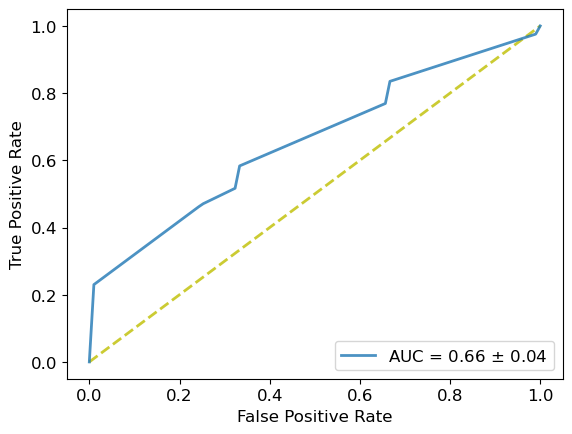

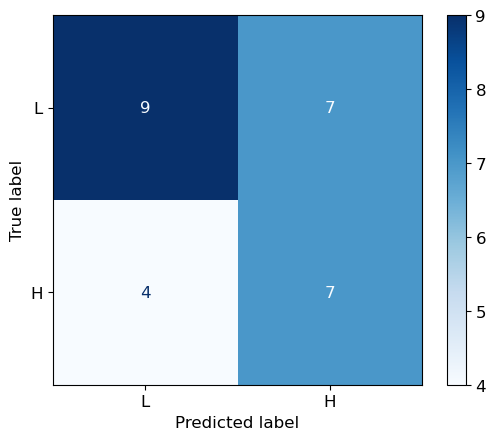

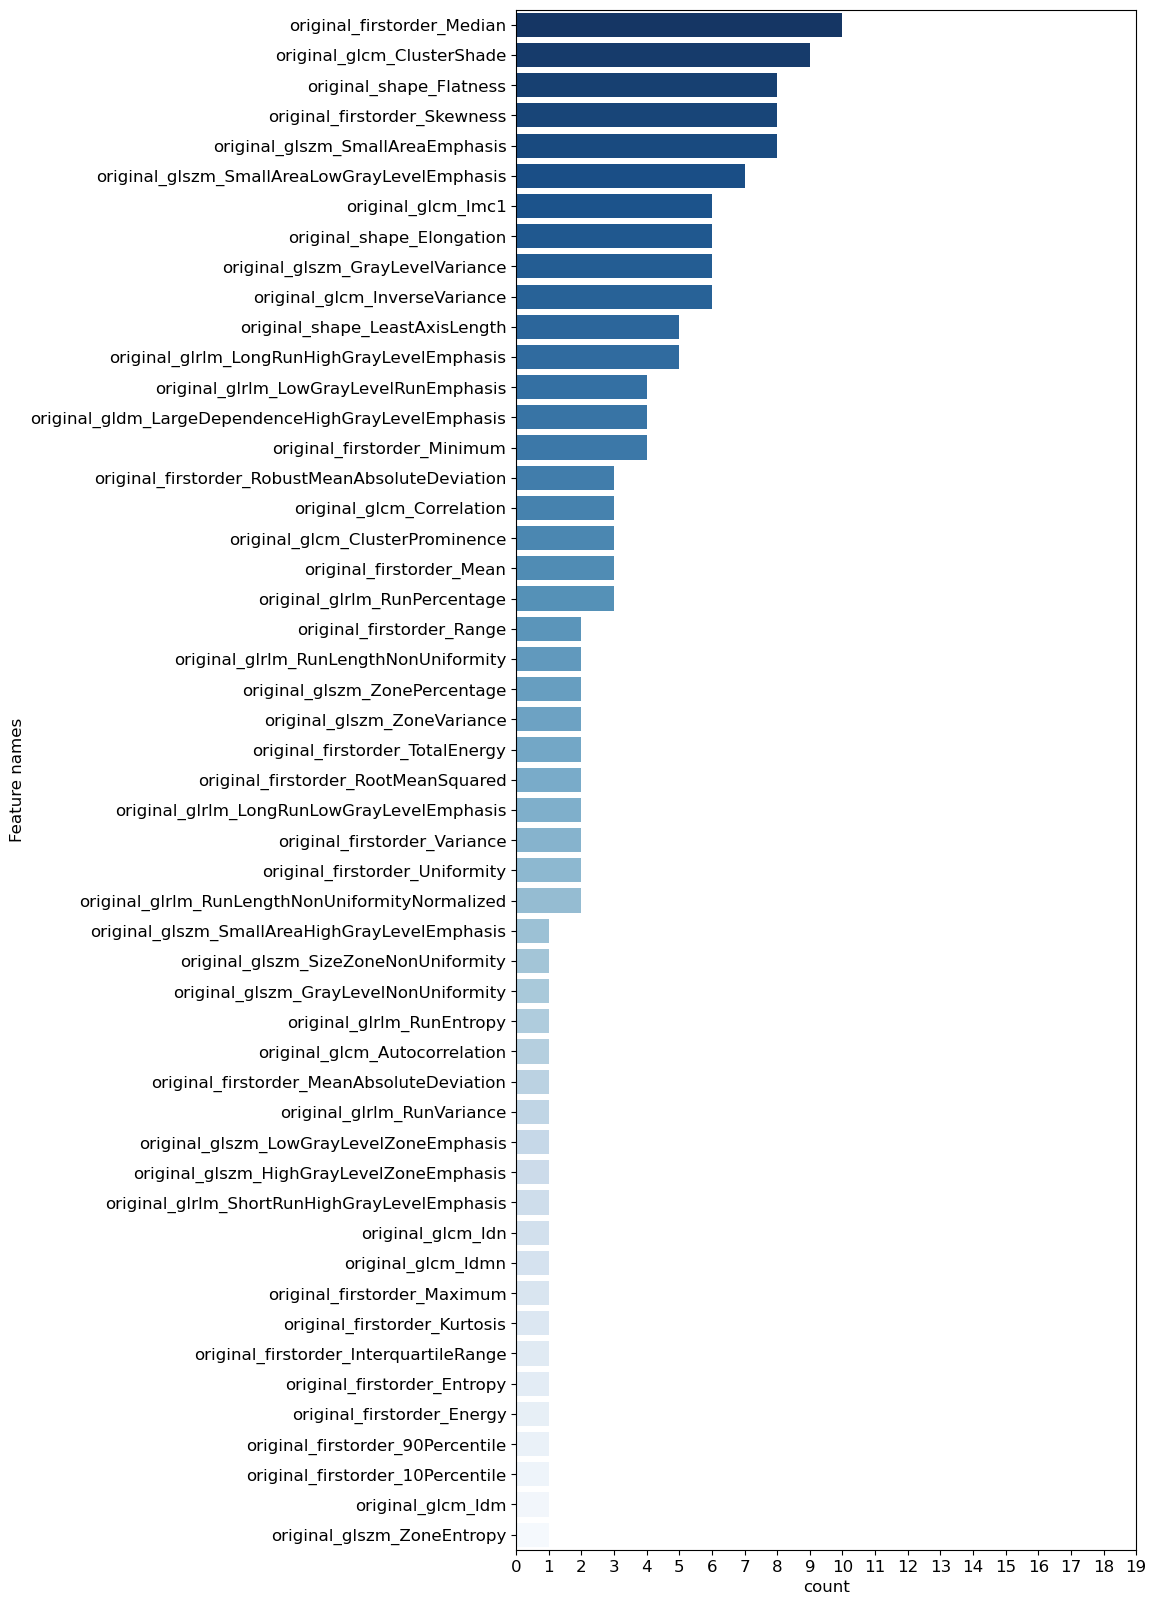

,Accuracy,Auc,Sensitivity(TPR),Specificity(TNR),F1 score
XGB,0.58±0.05,0.66±0.04,0.67±0.1,0.53±0.12,0.54±0.06


In [7]:
class Mypipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_ 

xgb_cons = 0
xgb_accs = []
xgb_aucs = [] 
xgb_sens = []
xgb_spes = []
xgb_f1s = []
xgb_tprs = []
n=0
xgb_feature_set = []
mean_fpr = np.linspace(0, 1, 100)       
for i in range(0,300,30):    
    #统计循环次数
    n=n+1
    print('第',n,'次循环')
    print('随机种子数为：',i)
    
    #设置分类器
    sm = SMOTE(random_state=i)
    clf = xgboost.XGBClassifier(random_state=1,n_jobs=-1)
    xgboost.set_config(verbosity=0) 
    estimator = ([("sample", sm),("clf", clf)])
    pipeline = Mypipeline(estimator)
    
    #xgbECV特征选择
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    rfecv = RFECV(pipeline, step=1, scoring='roc_auc',cv=cv)   
    rfecv.fit(X_data_1, y_data_1)
    print('RFECV 选择出的特征个数 ：' , rfecv.n_features_) 
    names = list(X_data_1.columns[rfecv.support_])
    xgb_feature_set.append(names)
    select_features = X_data_1.loc[:, names]
    print('选择的特征子集为：', names)
    g_scores = rfecv.grid_scores_
    indices = np.argsort(g_scores)[::-1]
   # print("Grid_Score: %f" % (g_scores[indices[0]]))
    
    #模型网格寻优
    model = Pipeline([("sample", sm),("clf", clf)])
    score={'AUC':'roc_auc', 'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}
    params = {'clf__colsample_bytree' : [0.1,0.5,0.9],
              'clf__gamma' : [0.1,0.5,0.9],
              'clf__learning_rate' : [0.01,0.05,0.08],
              'clf__max_depth' : [2,5,10],
              'clf__min_child_weight' : [3,5,10],
              'clf__n_estimators' : [2,5,10],          
              'clf__reg_alpha' : [1,4,10],
              'clf__reg_lambda' : [1,3,8],
              'clf__subsample' : [0.2,0.7,1]}   
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring=score,
                               n_jobs=-1,
                               refit='AUC',
                               return_train_score=True)
    grid_search.fit(select_features, y_data_1)
    print("模型最佳参数为：",grid_search.best_params_)
    print("模型最佳AUC为：", grid_search.best_score_)
    
    #用最优模型训练结果
    best_clf = grid_search.best_estimator_
    con = 0
    acc = []
    auc_ = [] 
    sen = []
    spe = []
    f1 = []
    tpr_ = []         
    for train_index, test_index in cv.split(select_features, y_data_1): 
        X_train = select_features.iloc[train_index] 
        y_train = y_data_1.iloc[train_index] 
        X_test = select_features.iloc[test_index]
        y_test = y_data_1.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred = best_clf.predict(X_test)
        proba = best_clf.predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tpr_.append(interp_tpr) 
        acc.append(accuracy_score(y_test, y_pred))
        auc_.append(roc_auc_score(y_test,proba))        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen.append(tp/(tp+fn))
        spe.append(tn/(fp+tn))
        f1.append(f1_score(y_test, y_pred))
        
        a=confusion_matrix(y_test,y_pred)
        con=con+a
   
    xgb_tprs.append(np.mean(tpr_, axis=0))
    xgb_accs.append(np.mean(acc))
    xgb_aucs.append(np.mean(auc_))  
    xgb_sens.append(np.mean(sen))
    xgb_spes.append(np.mean(spe))
    xgb_f1s.append(np.mean(f1))
    xgb_cons=xgb_cons+con
    
#ROC曲线 
matplotlib.rcParams.update({'font.size': 12})
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title=("Receiver operating characteristic")
plt.plot([0, 1], [0, 1], linestyle='--',color='y', lw=2, alpha=.8)
xgb_mean_tpr = np.mean(xgb_tprs, axis=0)
xgb_mean_tpr[-1] = 1.0
xgb_mean_auc = auc(mean_fpr, xgb_mean_tpr)
xgb_std_auc = np.std(xgb_aucs)
plt.plot(mean_fpr, xgb_mean_tpr, label=r'AUC = %0.2f $\pm$ %0.2f'% (xgb_mean_auc,xgb_std_auc),lw=2, alpha=.8)
plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.show()

#混淆矩阵      
class_names=['L','H']
disp = ConfusionMatrixDisplay(confusion_matrix=np.around(xgb_cons/n),display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show() 

#特征频率图可视化
xgb_select_names = pd.concat([pd.DataFrame(xgb_feature_set[i],columns=['Feature names']) for i in range(n)])
xgb_result=pd.DataFrame(pd.value_counts(xgb_select_names['Feature names']))
plt.figure(figsize=(8, 20))
f = sns.countplot(y='Feature names',data=xgb_select_names, order=xgb_result.index, palette='Blues_r')
                  #'Blues_r')
f.set_xticks(range(20))
plt.show()

#模型结果
xgb_result_dict = {'Accuracy': ['±'.join([str(round(np.mean(xgb_accs),2)),str(round(np.std(xgb_accs),2))])], 
                'Auc': ['±'.join([str(round(np.mean(xgb_aucs),2)),str(round(np.std(xgb_aucs),2))])], 
                'Sensitivity(TPR)': ['±'.join([str(round(np.mean(xgb_sens),2)),str(round(np.std(xgb_sens),2))])], 
                'Specificity(TNR)': ['±'.join([str(round(np.mean(xgb_spes),2)),str(round(np.std(xgb_spes),2))])], 
                'F1 score': ['±'.join([str(round(np.mean(xgb_f1s),2)),str(round(np.std(xgb_f1s),2))])] 
                }

result_xgb = pd.DataFrame(xgb_result_dict, index=['XGB'])
result_xgb

In [16]:
df = pd.DataFrame(data=svm_result, index=None)
df.to_excel(r'E:\Desktop\Desktop\Kidney\github\新数据集训练\svm_reslut.xlsx',index=None)

NameError: name 'svm_result' is not defined

In [12]:
xgb_result

,Feature names
original_firstorder_Median,10
original_glcm_ClusterShade,9
original_shape_Flatness,8
original_firstorder_Skewness,8
original_glszm_SmallAreaEmphasis,8
original_glszm_SmallAreaLowGrayLevelEmphasis,7
original_glcm_Imc1,6
original_shape_Elongation,6
original_glszm_GrayLevelVariance,6
original_glcm_InverseVariance,6


In [17]:
svm_mean_tpr=array([0.        , 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.82333333, 0.82333333, 0.82333333, 0.82333333, 0.82333333,
       0.82333333, 0.82333333, 0.82333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.94333333, 0.94333333, 0.94333333, 0.94333333, 0.94333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 0.96333333, 0.96333333, 0.96333333, 0.96333333,
       0.96333333, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [18]:
xgb_mean_tpr=array([0.        , 0.23006734, 0.24013468, 0.25020202, 0.26026936,
       0.2703367 , 0.28040404, 0.29047138, 0.30053872, 0.31060606,
       0.3206734 , 0.33074074, 0.34080808, 0.35087542, 0.36094276,
       0.3710101 , 0.38107744, 0.39114478, 0.40121212, 0.41127946,
       0.4213468 , 0.43141414, 0.44148148, 0.45154882, 0.46161616,
       0.47080808, 0.47737374, 0.48393939, 0.49050505, 0.49707071,
       0.50363636, 0.51020202, 0.51676768, 0.58333333, 0.58914141,
       0.59494949, 0.60075758, 0.60656566, 0.61237374, 0.61818182,
       0.6239899 , 0.62979798, 0.63560606, 0.64141414, 0.64722222,
       0.6530303 , 0.65883838, 0.66464646, 0.67045455, 0.67626263,
       0.68207071, 0.68787879, 0.69368687, 0.69949495, 0.70530303,
       0.71111111, 0.71691919, 0.72272727, 0.72853535, 0.73434343,
       0.74015152, 0.7459596 , 0.75176768, 0.75757576, 0.76338384,
       0.76919192, 0.835     , 0.83939394, 0.84378788, 0.84818182,
       0.85257576, 0.8569697 , 0.86136364, 0.86575758, 0.87015152,
       0.87454545, 0.87893939, 0.88333333, 0.88772727, 0.89212121,
       0.89651515, 0.90090909, 0.90530303, 0.90969697, 0.91409091,
       0.91848485, 0.92287879, 0.92727273, 0.93166667, 0.93606061,
       0.94045455, 0.94484848, 0.94924242, 0.95363636, 0.9580303 ,
       0.96242424, 0.96681818, 0.97121212, 0.97560606, 1.        ])

In [9]:
xgb_mean_auc

0.655981532496684

In [24]:
xgb_mean_auc=0.66

In [25]:
xgb_std_auc=0.04

In [10]:
xgb_std_auc

0.03678956675774021

In [19]:
rf_mean_tpr=array([0.        , 0.56414141, 0.56494949, 0.56575758, 0.56656566,
       0.56737374, 0.56818182, 0.5689899 , 0.56979798, 0.57060606,
       0.57141414, 0.57222222, 0.5730303 , 0.57383838, 0.57464646,
       0.57545455, 0.57626263, 0.57707071, 0.57787879, 0.57868687,
       0.57949495, 0.58030303, 0.58111111, 0.58191919, 0.58272727,
       0.63358586, 0.63459596, 0.63560606, 0.63661616, 0.63762626,
       0.63863636, 0.63964646, 0.64065657, 0.805     , 0.80540404,
       0.80580808, 0.80621212, 0.80661616, 0.8070202 , 0.80742424,
       0.80782828, 0.80823232, 0.80863636, 0.8090404 , 0.80944444,
       0.80984848, 0.81025253, 0.81065657, 0.81106061, 0.81146465,
       0.82186869, 0.82227273, 0.82267677, 0.82308081, 0.82348485,
       0.82388889, 0.82429293, 0.82469697, 0.82510101, 0.82550505,
       0.82590909, 0.82631313, 0.82671717, 0.82712121, 0.82752525,
       0.82792929, 0.915     , 0.91570707, 0.91641414, 0.91712121,
       0.91782828, 0.91853535, 0.91924242, 0.91994949, 0.92065657,
       0.95121212, 0.95171717, 0.95222222, 0.95272727, 0.95323232,
       0.95373737, 0.95424242, 0.95474747, 0.95525253, 0.95575758,
       0.95626263, 0.95676768, 0.95727273, 0.95777778, 0.95828283,
       0.95878788, 0.95929293, 0.95979798, 0.96030303, 0.96080808,
       0.96131313, 0.96181818, 0.96232323, 0.96282828, 1.        ])

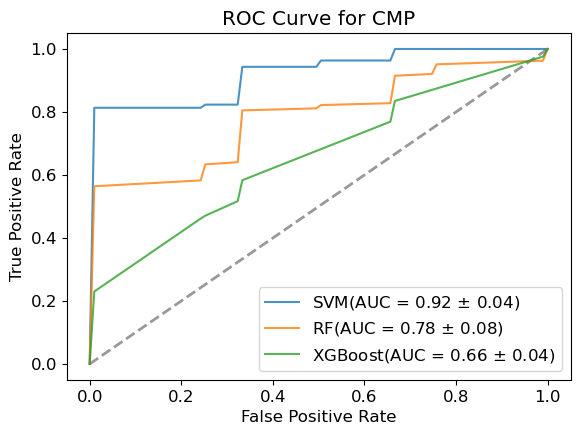

In [26]:
fig, ax = plt.subplots(figsize=(6.5,4.5))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,color='grey', 
         alpha=.8)

svm_mean_tpr[-1] = 1.0
#mean_auc_cmp = auc(mean_fpr, svm_mean_tpr)
ax.plot(mean_fpr, svm_mean_tpr, label=r'SVM(AUC = %0.2f $\pm$ %0.2f)'% (svm_mean_auc,svm_std_auc),lw=1.5, alpha=.8)

rf_mean_tpr[-1] = 1.0
#rf_mean_tpr = auc(mean_fpr, rf_mean_tpr)
ax.plot(mean_fpr, rf_mean_tpr, label=r'RF(AUC = %0.2f $\pm$ %0.2f)'% (rf_mean_auc,rf_std_auc),lw=1.5, alpha=.8)

xgb_mean_tpr[-1] = 1.0
#xgb_mean_auc = auc(mean_fpr, xgb_mean_auc)
ax.plot(mean_fpr, xgb_mean_tpr, label=r'XGBoost(AUC = %0.2f $\pm$ %0.2f)'% (xgb_mean_auc,xgb_std_auc),lw=1.5, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve for CMP")
ax.legend(loc="lower right")

plt.show()

In [ ]:
df = pd.DataFrame(data=mean_tpr, index=None)
df.to_excel(r'C:\Users\Administrator\Desktop\CMP-NP.xlsx',index=None)